In [13]:
'''
max_occlusion_2_anchor.pkl
    Useful anchor = 18974 / 46080 
    Most concentrated features pixel has 32.0 anchors
    Total anchor in heatmap = 18974.0
    There are 80 pixel that don't have anchors

max_occlusion_999_anchor.pkl
    Useful anchor = 19300 / 46080 
    Most concentrated features pixel has 32.0 anchors
    Total anchor in heatmap = 19300.0
    There are 80 pixel that don't have anchors

'''
import torch
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D, set_bev_background, draw_2Dbox
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD
from util_kitti import draw_corner_2D, draw_birdeyes, KITTI_Object, gac_original_anchor_parser

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2

# assume crop_top 100 pixel and resize into (288, 1280)
CROP_TOP = 100
img_new_h, img_new_w = (288, 1280) # img_new_h, img_new_w

# This script will generate 3D anchors based on my prior knowldged
img = cv2.imread("/home/lab530/KenYu/kitti/training/image_2/000169.png")
img_ori_h, img_ori_w, _ = img.shape
img_crp_h = img_ori_h - CROP_TOP

# Assuming croptop 100 pixel + resize into (288, 1280) - preservse aspect ratio
img_tf = cv2.resize(img[CROP_TOP:, :], (int(img_ori_w * img_new_h / img_crp_h), 
                                        int(img_crp_h * img_new_h / img_crp_h)))
# crop in
if img_tf.shape[1] > img_new_w:
    img_tf = img_tf[:, 0:img_new_w, :]
elif img_tf.shape[1] < img_new_w: # pad out
    img_tf = np.pad(img_tf,  [(0, 0), (0, img_new_w - img_tf.shape[1]), (0, 0)], 'constant')
# print(f"img_tf = {img_tf.shape}") # (288, 1280)

# Draw few anchors from GAC 

In [14]:
%%script false --no-raise-error
# Load my anchor
pos_inds_my = torch.tensor([3015, 3017, 3019, 3021, 6487, 6585, 6587, 6589, 7102, 7129, 7140, 7142, 7163, 7165, 7167, 7172])
n_pos_my = pos_inds_my.shape[0]
print(f"n_pos_my = {n_pos_my}")

# Load GAC's anchor
with open("/home/lab530/KenYu/visualDet3D/GAC_head_anchor_2D.pkl", 'rb') as f:
    GAC_head_anchor_2D = pickle.load(f)
with open("/home/lab530/KenYu/visualDet3D/GAC_head_anchor_3D.pkl", 'rb') as f:
    GAC_head_anchor_3D = pickle.load(f)

fig = plt.figure(figsize=(18, 15), dpi=100)
plt.subplots_adjust(wspace=0, hspace=0)

gs = GridSpec(2, 4)
gs.update(wspace=0)  # set the spacing between axes.
ax_img_my = fig.add_subplot(gs[0, :3])
ax_bev_my = fig.add_subplot(gs[0,  3])
ax_img_gac = fig.add_subplot(gs[1, :3])
ax_bev_gac = fig.add_subplot(gs[1,  3])

# for i in range(n_pos_my):
#     color = (random.random(), random.random(), random.random())
#     draw_corner_2D(ax_img_my, anchors[pos_inds_my[i]].corner_2D, color = color)
#     draw_birdeyes(ax_bev_my, anchors[pos_inds_my[i]], color = color)

# Draw GAC anchors 
for i in range(GAC_head_anchor_2D.shape[0]):
    color = (random.random(), random.random(), random.random())
    
    cx = (GAC_head_anchor_2D[i, 2] + GAC_head_anchor_2D[i, 0]) / 2.0
    cy = (GAC_head_anchor_2D[i, 3] + GAC_head_anchor_2D[i, 1]) / 2.0
    cz =  GAC_head_anchor_3D[i, 0, 0]
    # print(f"(cx, cy, cz) = {np.array([[cx], [cy], [cz]])}")

    loc_3d = np.linalg.inv(P2_tf[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
    loc_3d[1, 0] += GAC_head_anchor_3D[i, 4, 0] / 2.0

    # Get observation angle: alpha
    alpha = atan2(GAC_head_anchor_3D[i, 1, 0], GAC_head_anchor_3D[i, 2, 0]) / 2.0
    rot_y = alpha - atan2(loc_3d[2, 0], loc_3d[0, 0]) + pi/2
    
    # alpha in [-pi, pi]
    if   rot_y >  pi: rot_y -= 2*pi
    elif rot_y < -pi: rot_y += 2*pi

    corner_2D = get_corner_2D(P2_tf, (loc_3d[0, 0], loc_3d[1, 0], loc_3d[2, 0]),
                                rot_y,
                                (GAC_head_anchor_3D[i, 5, 0], 
                                 GAC_head_anchor_3D[i, 4, 0], 
                                 GAC_head_anchor_3D[i, 3, 0]))
    # print(f"loc_3d = {loc_3d}")
    dimension = (GAC_head_anchor_3D[i, 4, 0], GAC_head_anchor_3D[i, 3, 0], GAC_head_anchor_3D[i, 5, 0])
    a = Anchor(loc_3d[0, 0], loc_3d[1, 0], loc_3d[2, 0], rot_y, True, dimension = dimension)

    draw_corner_2D(ax_img_gac, corner_2D, color = (random.random(), random.random(), random.random()))
    draw_birdeyes (ax_bev_gac, a, color = color)

fig.set_facecolor('white')
fig.tight_layout()

# Visualize BEV
# plot camera view range
BEV_SHAPE = 900
x1 = np.linspace(0, BEV_SHAPE/2)
x2 = np.linspace(BEV_SHAPE/2, BEV_SHAPE)
ax_bev_my.plot(x1, BEV_SHAPE / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_my.plot(x2, x2 - BEV_SHAPE / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_my.plot(BEV_SHAPE / 2, 0, marker='+', markersize=16, markeredgecolor='red')
ax_bev_my.imshow(np.zeros((BEV_SHAPE, BEV_SHAPE, 3), np.uint8), origin='lower')
ax_bev_my.set_xticks([])
ax_bev_my.set_yticks([])

ax_img_my.axis('off')
ax_img_my.imshow(img_tf[...,::-1])

############################################

ax_bev_gac.plot(x1, BEV_SHAPE / 2 - x1, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_gac.plot(x2, x2 - BEV_SHAPE / 2, ls='--', color='grey', linewidth=1, alpha=0.5)
ax_bev_gac.plot(BEV_SHAPE / 2, 0, marker='+', markersize=16, markeredgecolor='red')
ax_bev_gac.imshow(np.zeros((BEV_SHAPE, BEV_SHAPE, 3), np.uint8), origin='lower')
ax_bev_gac.set_xticks([])
ax_bev_gac.set_yticks([])

ax_img_gac.axis('off')
ax_img_gac.imshow(img_tf[...,::-1])


## Draw ALL anchor in GAC

In [15]:
%%script false --no-raise-error
COR_ANCHOR_SHOW = (4, 46)

# Load GAC's anchor
anchor_2D, anchor_3D, anchor_mask, anchor_objects = gac_original_anchor_parser("/home/lab530/KenYu/visualDet3D/anchor/max_occlusion_2_anchor.pkl", is_transform = True)

# Draw heat data
heat_data = np.zeros(shape=(18, 80))
for a in anchor_objects:
    if 0 <= a.cx_f_index < 80 and 0 <= a.cy_f_index < 18:
        heat_data[a.cy_f_index, a.cx_f_index] += 1
print(f"Most concentrated features pixel has {heat_data.max()} anchors" )
print(f"Total anchor in heatmap = {heat_data.sum()}")
print(f"There are {18*80 - np.count_nonzero(heat_data)} pixel that don't have anchors")

fig = plt.figure(figsize=(18, 15), dpi=100)
plt.subplots_adjust(wspace=0, hspace=0)

gs = GridSpec(4, 4)
gs.update(wspace=0)  # set the spacing between axes.
ax_img_2dbox = fig.add_subplot(gs[0, :3])
ax_bev_unfiltered = fig.add_subplot(gs[0,  3])
ax_img_3dbox   = fig.add_subplot(gs[1, :3])
ax_bev_filtered   = fig.add_subplot(gs[1,  3])
ax_heat_data      = fig.add_subplot(gs[2,  :])

# #
# ax_img_all_unfiltered = fig.add_subplot(gs[2, :3])
# ax_bev_all_unfiltered = fig.add_subplot(gs[2,  3])
# ax_img_all_filtered   = fig.add_subplot(gs[3, :3])
# ax_bev_all_filtered   = fig.add_subplot(gs[3,  3])

# Draw GAC anchors
c = 0
# for i in range(anchor_2D.shape[0]):
for a in anchor_objects:
    c += 1
    rnd_color = (random.random(), random.random(), random.random())
    
    # Draw only one pixel's anchor 
    if (a.cy_f_index, a.cx_f_index) == COR_ANCHOR_SHOW:
        # Draw filter bbox 
        
        draw_2Dbox(ax_img_2dbox, (a.xmin, a.ymin, a.xmax, a.ymax), color = (1,0,0))
        draw_corner_2D(ax_img_3dbox, a.corner_2D, color = rnd_color, is_draw_front = False)
        draw_birdeyes (ax_bev_filtered, a, color = rnd_color)
    
    # Output all anchors?
    # # Draw Unfilter bbox for all anchors
    # draw_corner_2D(ax_img_all_unfiltered, corner_2D, color = rnd_color, is_draw_front = False)
    # draw_birdeyes (ax_bev_all_unfiltered, a, color = rnd_color)

    # # Draw filter bbox for all anchors
    # if anchor_mask[i]:
    #     draw_corner_2D(ax_img_all_filtered, corner_2D, color = rnd_color, is_draw_front = False)
    #     draw_birdeyes (ax_bev_all_filtered, a, color = rnd_color)


fig.set_facecolor('white')
fig.tight_layout()

# Set up background
set_bev_background(ax_bev_unfiltered)
set_bev_background(ax_bev_filtered)
# set_bev_background(ax_bev_all_unfiltered)
# set_bev_background(ax_bev_all_filtered)

ax_img_2dbox.axis('off')
ax_img_2dbox.imshow(img_tf[...,::-1])

ax_img_3dbox.axis('off')
ax_img_3dbox.imshow(img_tf[...,::-1])

ax_heat_data.axis('off')
ax_heat_data.imshow(heat_data, cmap='hot', interpolation='nearest')
# plt.imshow(heat_data, cmap='hot', interpolation='nearest')

# ax_img_all_filtered.axis('off')
# ax_img_all_filtered.imshow(img_tf[...,::-1])

# ax_img_all_unfiltered.axis('off')
# ax_img_all_unfiltered.imshow(img_tf[...,::-1])


# Draw 2D Anchor from RetinaNet

(288, 1280, 3)
(level, anchor_w, anchor_h) = (0, 45.254833, 22.627417)
(level, anchor_w, anchor_h) = (0, 57.017517, 28.508759)
(level, anchor_w, anchor_h) = (0, 71.83757, 35.918785)
(level, anchor_w, anchor_h) = (0, 32.0, 32.0)
(level, anchor_w, anchor_h) = (0, 40.317474, 40.317474)
(level, anchor_w, anchor_h) = (0, 50.796833, 50.796833)
(level, anchor_w, anchor_h) = (0, 22.627417, 45.254833)
(level, anchor_w, anchor_h) = (0, 28.508759, 57.017517)
(level, anchor_w, anchor_h) = (0, 35.918785, 71.83757)
(level, anchor_w, anchor_h) = (1, 90.50967, 45.254833)
(level, anchor_w, anchor_h) = (1, 114.035034, 57.017517)
(level, anchor_w, anchor_h) = (1, 143.67514, 71.83757)
(level, anchor_w, anchor_h) = (1, 64.0, 64.0)
(level, anchor_w, anchor_h) = (1, 80.63495, 80.63495)
(level, anchor_w, anchor_h) = (1, 101.593666, 101.593666)
(level, anchor_w, anchor_h) = (1, 45.254833, 90.50967)
(level, anchor_w, anchor_h) = (1, 57.017517, 114.035034)
(level, anchor_w, anchor_h) = (1, 71.83757, 143.67514)
(

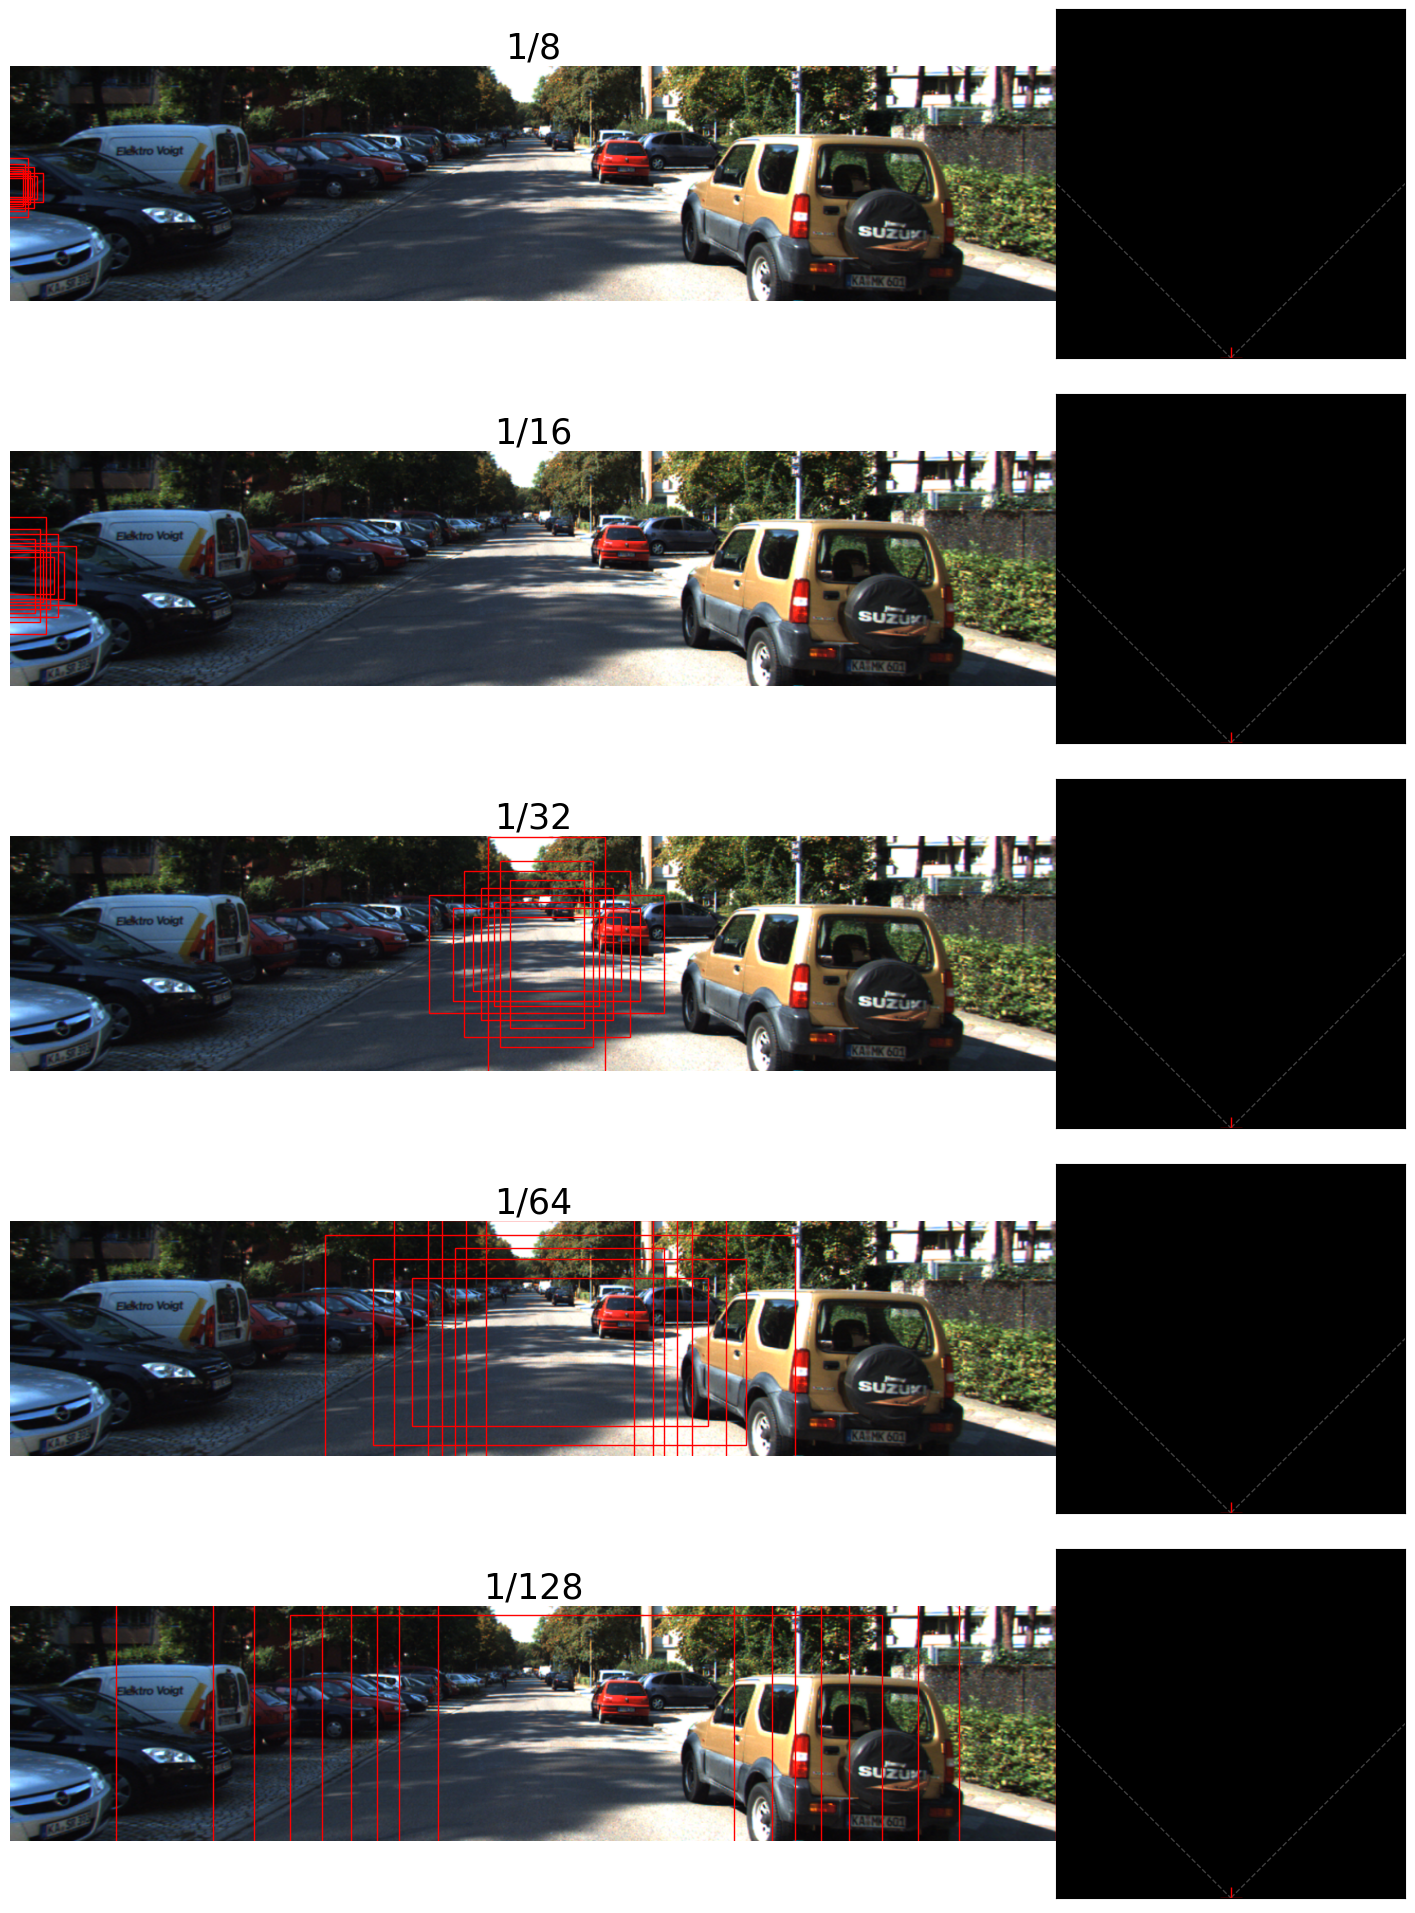

In [47]:
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import draw_2Dbox, init_img_plt

# Load GAC's anchor
with open("/home/lab530/KenYu/visualDet3D/retinanet_2d_anchor.pkl", 'rb') as f:
    GAC_head_anchor_2D = pickle.load(f)
    GAC_head_anchor_2D = GAC_head_anchor_2D[0, :, :].cpu().numpy()
print(img_tf.shape)

axs = init_img_plt([img_tf, img_tf, img_tf, img_tf, img_tf], 
                    titles = ["1/8", "1/16", "1/32", "1/64", "1/128"])

# Draw GAC anchors
for i in range(GAC_head_anchor_2D.shape[0]):
    color = (random.random(), random.random(), random.random())
    level_ranges = [0, 51840, 64800, 68040, 68940, 69210]
    level = 5
    while level_ranges[level] > i: level -= 1
    
    if i < level_ranges[level] + 9:
        width  = GAC_head_anchor_2D[i, 2] - GAC_head_anchor_2D[i, 0]
        height = GAC_head_anchor_2D[i, 3] - GAC_head_anchor_2D[i, 1]
        print(f"(level, anchor_w, anchor_h) = {(level, width, height)}")
    
    x = level_ranges[level] + int( (level_ranges[level+1] - level_ranges[level]) / 18 ) * 9
    
    if x <= i < x+9:
        draw_2Dbox(axs[level][0], (GAC_head_anchor_2D[i, 0],
                                    GAC_head_anchor_2D[i, 1],
                                    GAC_head_anchor_2D[i, 2],
                                    GAC_head_anchor_2D[i, 3]), color = (1,0,0))
    
    # Draw all anchor, this will take a while
    # draw_2Dbox(axs[idx_img][0], (GAC_head_anchor_2D[i, 0],
    #                              GAC_head_anchor_2D[i, 1],
    #                              GAC_head_anchor_2D[i, 2],
    #                              GAC_head_anchor_2D[i, 3]), color = color)
    
# 69210  = 51840  + 12960 + 3240 + 900  + 270